In [1]:
!pip install pyarrow

     |████████████████████████████████| 26.7 MB 4.7 MB/s            


In [2]:
!pip3 install torch==1.10.1+cpu  -f https://download.pytorch.org/whl/cpu/torch_stable.html

Looking in links: https://download.pytorch.org/whl/cpu/torch_stable.html
     |████████████████████████████████| 199.3 MB 36 kB/s              �███████▏           | 125.7 MB 3.2 MB/s eta 0:00:24 


In [3]:
!pip3 install transformers

     |████████████████████████████████| 3.5 MB 4.7 MB/s            
     |████████████████████████████████| 895 kB 60.6 MB/s            
     |████████████████████████████████| 596 kB 49.2 MB/s            
     |████████████████████████████████| 6.8 MB 59.4 MB/s            
     |████████████████████████████████| 748 kB 50.8 MB/s            
     |████████████████████████████████| 67 kB 7.7 MB/s             
     |████████████████████████████████| 306 kB 66.4 MB/s            


In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax

from transformers import pipeline

In [6]:
import warnings
warnings.filterwarnings("ignore")


from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [9]:
fakeNews = pd.read_feather('https://github.com/thousandoaks/TopicsInDataAnalysisDataStore/blob/main/train.ftr?raw=true')

In [15]:
fakeNews.sample(3)

,id,title,author,text,label
10767,10767,“Brexit means Clusterfuck” confirms Prime Mini...,None,“Brexit means Clusterfuck” confirms Prime Mini...,1
8839,8839,Bernie Sanders Refuses to Concede Nomination t...,Yamiche Alcindor,Senator Bernie Sanders said on Sunday that he ...,0
2904,2904,Michael Moore SHOCKS the Internet: “If You Mak...,The Conservative Millennial,0 comments \nIn a four-minute speech beforeÂ a...,1


# 1. Basic Exploratory Analysis

In [16]:
fakeNews.groupby('label').count()

,id,title,author,text
label,,,,
0,10387,10387,10361,10387
1,10413,9855,8482,10374


## 1.1. Emotion Analysis
### Is there any relationship between emotions and fakeness ?

In [10]:
tokenizer = AutoTokenizer.from_pretrained("bhadresh-savani/distilbert-base-uncased-emotion")

model = AutoModelForSequenceClassification.from_pretrained("bhadresh-savani/distilbert-base-uncased-emotion")

Downloading:   0%|          | 0.00/291 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/768 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/255M [00:00<?, ?B/s]

In [19]:
#classifier = pipeline('sentiment-analysis', model=model, tokenizer=tokenizer)

classifier = pipeline("text-classification",model='bhadresh-savani/distilbert-base-uncased-emotion', return_all_scores=False)

In [20]:
fakeNews.dropna(subset=['title'],inplace=True)

In [11]:
fakeNewsSample=fakeNews.sample(40)

In [22]:
#classifier(mini['title'].tolist())

In [23]:
import time
start_time = time.time()
fakeNewsSample['text.classification']=fakeNewsSample['title'].apply(lambda x:classifier(x))

print("--- %s seconds ---" % (time.time() - start_time))

--- 5.786192417144775 seconds ---


In [24]:
fakeNewsSample['emotion.label']=fakeNewsSample['text.classification'].apply(lambda x:x[0]['label'])
fakeNewsSample['emotion.intensity']=fakeNewsSample['text.classification'].apply(lambda x:x[0]['score'])

In [25]:
fakeNewsSample.head(3)

,id,title,author,text,label,text.classification,emotion.label,emotion.intensity
10032,10032,"Meet the New Monopoly Tokens: A Rubber Ducky, ...",Christine Hauser,"Say goodbye to the thimble, the boot and the w...",0,"[{'label': 'anger', 'score': 0.5991294384002686}]",anger,0.599129
11341,11341,Justice Dept. Strongly Discouraged Comey on Mo...,"Matt Apuzzo, Adam Goldman, Michael S. Schmidt ...",WASHINGTON — The day before the F. B. I. di...,0,"[{'label': 'sadness', 'score': 0.9038107991218...",sadness,0.903811
12849,12849,H.I.V. Arrived in the U.S. Long Before ‘Patien...,Donald G. McNeil Jr.,In the tortuous mythology of the AIDS epidemic...,0,"[{'label': 'fear', 'score': 0.5295730829238892}]",fear,0.529573


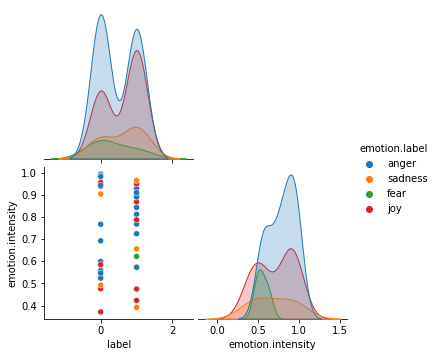

In [26]:
sns.pairplot(fakeNewsSample[['label','emotion.label','emotion.intensity']], hue="emotion.label",corner=True)

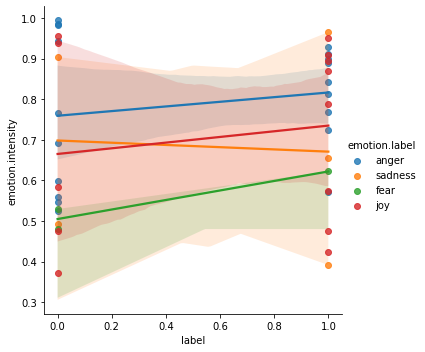

In [27]:
g = sns.lmplot(
    data=fakeNewsSample[['label','emotion.label','emotion.intensity']],
    x="label", y="emotion.intensity", hue="emotion.label",
    height=5
)

## Are emotions useful to spot FakeNews ??
### Tip: have a look at the histograms

## 1.2. text Analysis
### Is there any relationship between text characteristics and fakeness ?

In [28]:
fakeNews['title.length']=fakeNews['title'].apply(lambda x:len(x))

In [29]:
fakeNews.dropna(subset=['text'],inplace=True)

In [30]:
fakeNews['text.length']=fakeNews['text'].apply(lambda x:len(x))

In [31]:
fakeNews[['label','text.length','title.length']].head()

,label,text.length,title.length
0,1,4930,81
1,0,4160,55
2,1,7692,33
3,1,3237,63
4,1,938,93


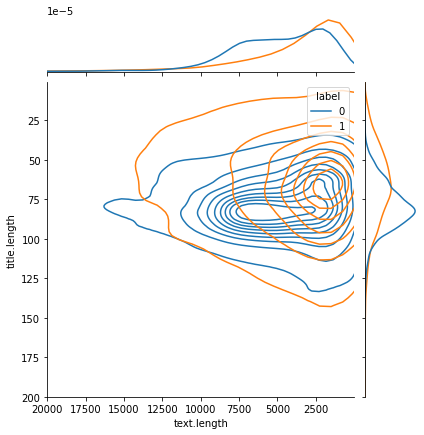

In [32]:
g = sns.jointplot(
    data=fakeNews[['label','text.length','title.length']],
    x="text.length", y="title.length", hue="label",xlim=20000,ylim=200,
    kind="kde",
)

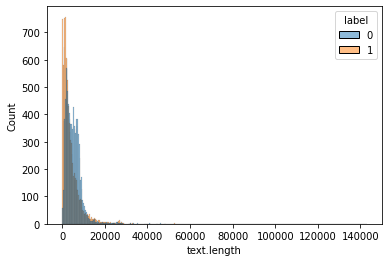

In [33]:
sns.histplot(data=fakeNews[['label','text.length','title.length']], x="text.length", hue="label")

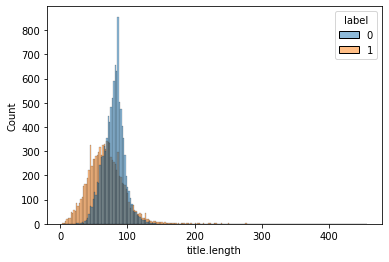

In [34]:
sns.histplot(data=fakeNews[['label','text.length','title.length']], x="title.length", hue="label")

## Thoughts ??

## 1.3. Text readibility

In [1]:
!pip install -U spacy

In [2]:
!pip install spacy-readability

  Using cached spacy-2.3.7-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (10.4 MB)
  Using cached catalogue-1.0.0-py2.py3-none-any.whl (7.7 kB)
  Using cached thinc-7.4.5-cp37-cp37m-manylinux2014_x86_64.whl (1.0 MB)
  Using cached srsly-1.0.5-cp37-cp37m-manylinux2014_x86_64.whl (184 kB)
  Attempting uninstall: srsly
    Found existing installation: srsly 2.4.2
    Uninstalling srsly-2.4.2:
      Successfully uninstalled srsly-2.4.2
  Attempting uninstall: catalogue
    Found existing installation: catalogue 2.0.6
    Uninstalling catalogue-2.0.6:
      Successfully uninstalled catalogue-2.0.6
  Attempting uninstall: thinc
    Found existing installation: thinc 8.0.13
    Uninstalling thinc-8.0.13:
      Successfully uninstalled thinc-8.0.13
  Attempting uninstall: spacy
    Found existing installation: spacy 3.2.1
    Uninstalling spacy-3.2.1:
      Successfully uninstalled spacy-3.2.1


In [3]:
import spacy
from spacy_readability import Readability

In [4]:
!python -m spacy download en_core_web_sm

  Using cached en_core_web_sm-2.3.1-py3-none-any.whl
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [25]:
nlp2 = spacy.load('en_core_web_sm')

nlp2.add_pipe(Readability())


In [26]:
doc = nlp2("I am some really difficult text to read because I use obnoxiously large words.")

In [27]:
doc._.flesch_kincaid_grade_level

8.412857142857145

In [28]:
fakeNewsSample2=fakeNewsSample.sample(30)

In [29]:
fakeNewsSample2['text.nlp']=fakeNewsSample2['text'].apply(lambda x:nlp2(x))
fakeNewsSample2['title.nlp']=fakeNewsSample2['title'].apply(lambda x:nlp2(x))

In [30]:
fakeNewsSample2['text.automated_readability_index']=fakeNewsSample2['text.nlp'].apply(lambda x:x._.automated_readability_index)
fakeNewsSample2['title.automated_readability_index']=fakeNewsSample2['title.nlp'].apply(lambda x:x._.automated_readability_index)

In [31]:
fakeNewsSample2['text.flesch_kincaid_reading_ease']=fakeNewsSample2['text.nlp'].apply(lambda x:x._.flesch_kincaid_reading_ease)
fakeNewsSample2['title.flesch_kincaid_reading_ease']=fakeNewsSample2['title.nlp'].apply(lambda x:x._.flesch_kincaid_reading_ease)

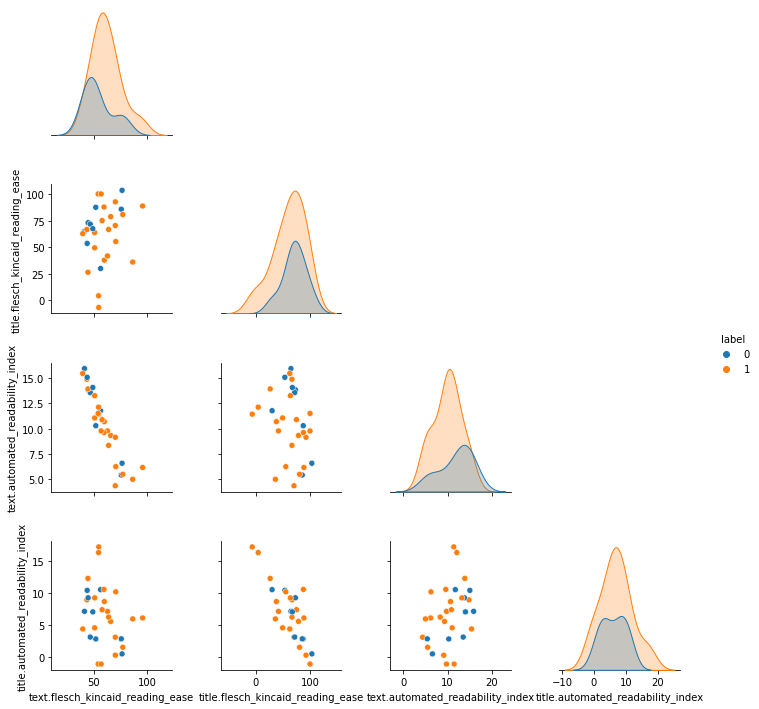

In [32]:
sns.pairplot(fakeNewsSample2[['label','text.flesch_kincaid_reading_ease','title.flesch_kincaid_reading_ease','text.automated_readability_index','title.automated_readability_index']], hue="label",corner=True)

## 1.4. Text entities

In [33]:
text='Hi there, I am in Japan'

In [34]:
doc=nlp2(text)

In [35]:
for ent in doc.ents:
    print(ent.text,  ent.label_)

Japan GPE


In [36]:
fakeNewsSample2['title.entities']=fakeNewsSample2['title.nlp'].apply(lambda x:[e.label_ for e in x.ents])


In [37]:
fakeNewsSample2[fakeNewsSample2['label']==0]['title.entities']

9352                                       [DATE]
13567       [PERSON, PERSON, PERSON, WORK_OF_ART]
15076    [ORG, PERSON, DATE, PERSON, WORK_OF_ART]
967                               [ORG, ORG, ORG]
19007                             [ORG, GPE, GPE]
12462                         [PERSON, NORP, LAW]
3797                                 [GPE, MONEY]
2820                                           []
9828                                     [PERSON]
Name: title.entities, dtype: object

In [38]:
notFakeEntities=pd.DataFrame()
notFakeEntities['entity']=fakeNewsSample2[fakeNewsSample2['label']==0]['title.entities'].explode()
notFakeEntities['label']=0

In [39]:
FakeEntities.head(3)

NameError: name 'FakeEntities' is not defined

In [40]:
FakeEntities=pd.DataFrame()
FakeEntities['entity']=fakeNewsSample2[fakeNewsSample2['label']==1]['title.entities'].explode()
FakeEntities['label']=1

In [41]:
FakeEntities.head(3)

,entity,label
4074,DATE,1
17781,DATE,1
17781,CARDINAL,1


In [42]:
notFakeEntities.groupby('entity').count().reset_index()

,entity,label
0,DATE,2
1,GPE,3
2,LAW,1
3,MONEY,1
4,NORP,1
5,ORG,5
6,PERSON,7
7,WORK_OF_ART,2


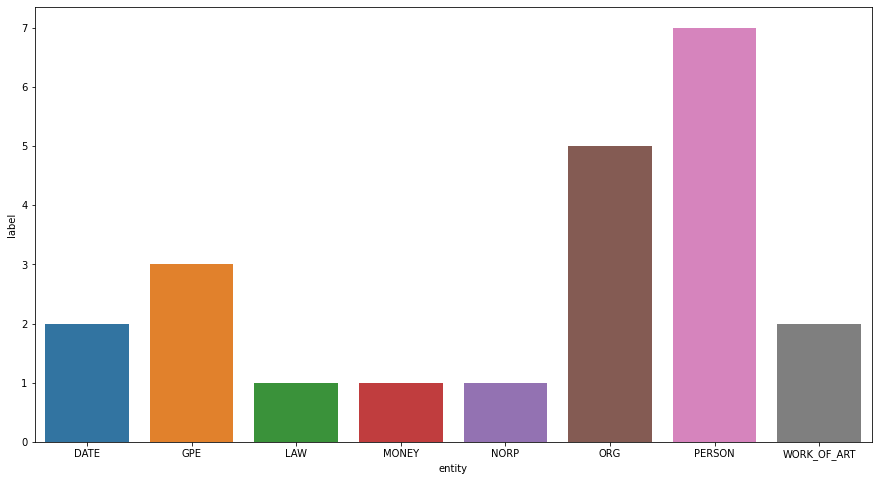

In [43]:
plt.figure(figsize=(15,8))
sns.barplot( x='entity',y='label',data=notFakeEntities.groupby('entity').count().reset_index())

In [44]:
FakeEntities.groupby('entity').count()

,label
entity,
CARDINAL,3
DATE,4
GPE,3
LANGUAGE,1
LAW,1
LOC,1
NORP,2
ORDINAL,1
ORG,4


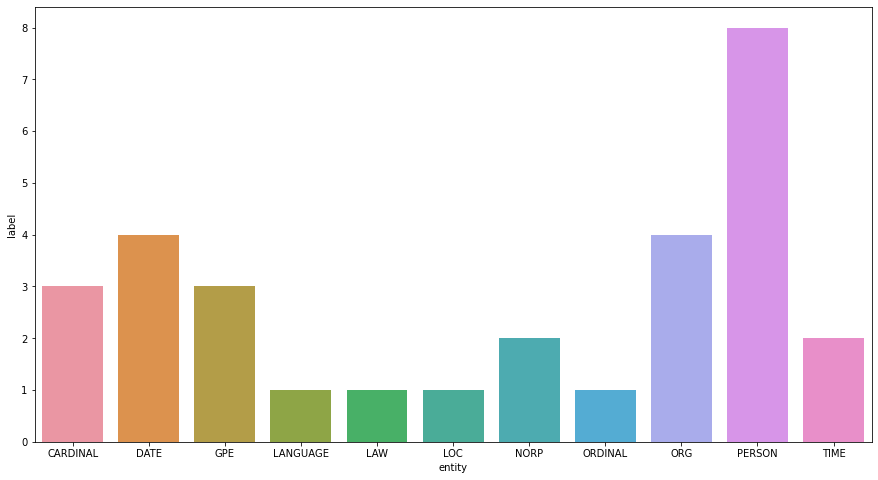

In [45]:
plt.figure(figsize=(15,8))
sns.barplot( x='entity',y='label',data=FakeEntities.groupby('entity').count().reset_index())

# Thoughts ??